In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [2]:
train_data = pd.read_csv("digit-recognizer/train.csv")
test_data = pd.read_csv("digit-recognizer/test.csv")

In [3]:
print(train_data.shape);train_data.head(5)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_data.drop("label", axis=1)
y_train = train_data.label

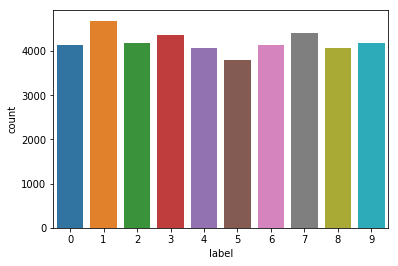

In [7]:
sns.countplot(y_train)

In [8]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
#grayscale normalization
X_train = X_train/255.
test_data = test_data/255.

In [10]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test_data = test_data.values.reshape(-1, 28, 28, 1)

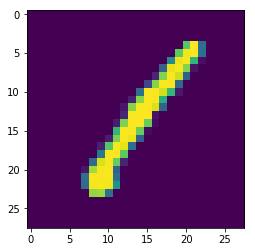

In [11]:
plt.imshow(X_train[0][:,:,0])

In [12]:
#encoding
y_train = to_categorical(y_train, num_classes=10); y_train.shape

(42000, 10)

In [14]:
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=420)

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, MaxPool2D, Dense
from keras.losses import categorical_crossentropy

In [43]:
model = Sequential()

model.add(Conv2D(filters=64, input_shape=(28,28,1), kernel_size=(5,5), activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 20, 20, 64)        102464    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               1638656   
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
Total params: 1,745,354
Trainable params: 1,745,354
Non-trainable params: 0
___________________________________________

In [51]:
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=[X_val, y_val])

Train on 37800 samples, validate on 4200 samples
Epoch 1/3
37800/37800 [==============================] - 179s 5ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0415 - val_accuracy: 0.9883
Epoch 2/3
37800/37800 [==============================] - 172s 5ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0444 - val_accuracy: 0.9855
Epoch 3/3
37800/37800 [==============================] - 175s 5ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0395 - val_accuracy: 0.9905


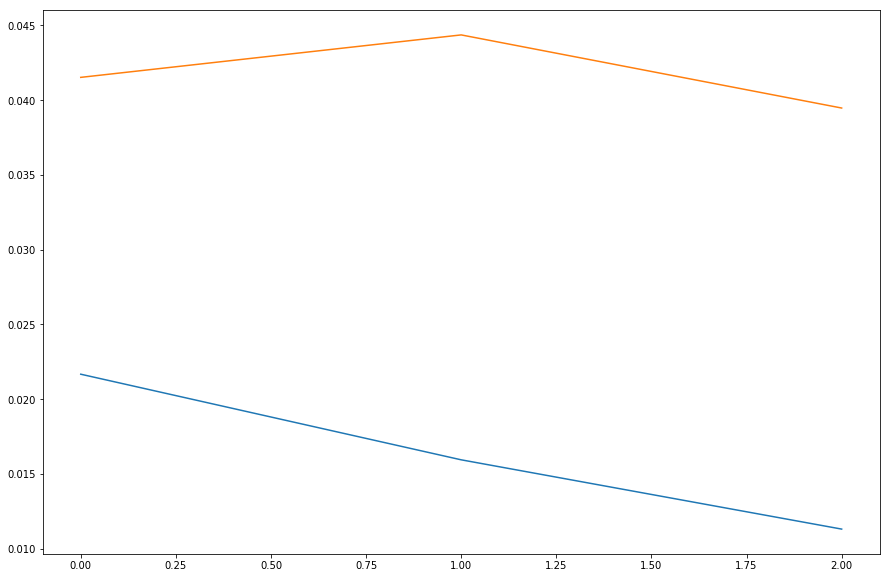

In [53]:
plt.figure(figsize=[8,10])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])